---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 
- input: *.fits
- output: *.fits

STEP 1: file load. 

In [317]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import struct
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2
from PIL import Image

In [318]:
path0 = '/Volumes/WD1T/share/TSE2023/'   
path1 = '/Volumes/WD1T/share/TSE2023/iPhone/result/'    
dirr2t = path1 + 'r2dfdatat/'           # input: registration 2nd

dirpol = path1 + 'pol_rot_r2dfdata/'    # output dir
if not os.path.exists(dirpol ):
    os.makedirs(dirpol )

In [319]:
import os
import glob

# delete ._* files
files_to_delete = glob.glob(os.path.join(dirr2t, '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [320]:
# preview the input dir
pathd = dirr2t 
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['r2_r1_image_00000.fits', 'r2_r1_image_00001.fits', 'r2_r1_image_00002.fits', 'r2_r1_image_00003.fits', 'r2_r1_image_00004.fits', 'r2_r1_image_00005.fits', 'r2_r1_image_00006.fits', 'r2_r1_image_00007.fits', 'r2_r1_image_00008.fits', 'r2_r1_image_00009.fits']
13301


---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 

STEP 2: rotation of the img, and then transfer to the polar form
- find the rotation center

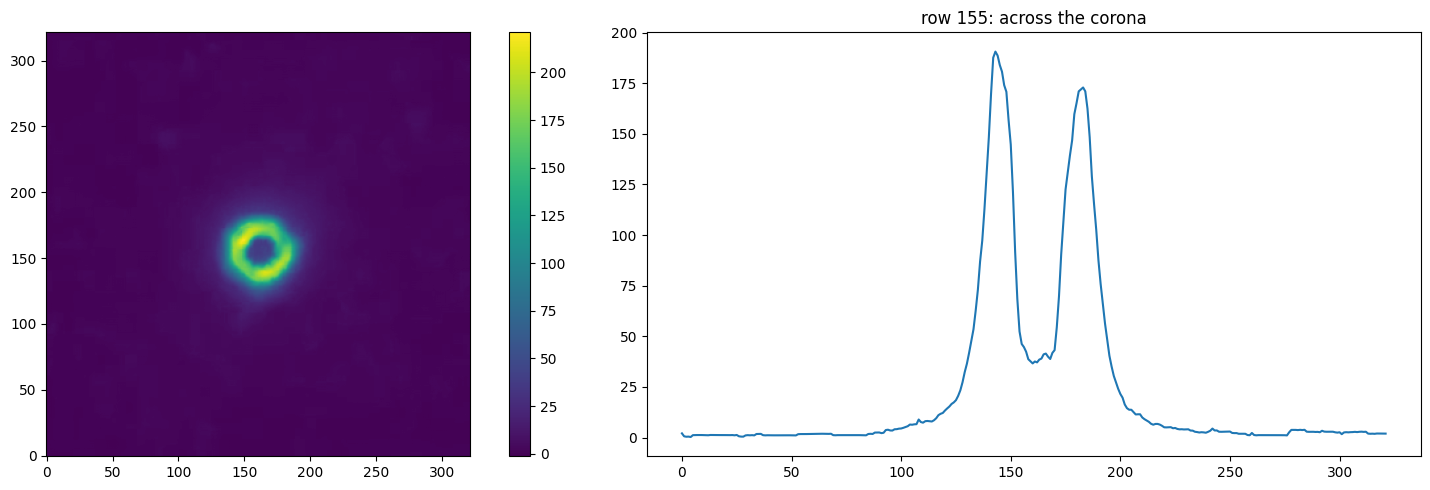

In [321]:
hdu2 = fits.open(pathd + listd[st + 6000])
img2 = hdu2[0].data

imgtmp = img2.copy()

m,n = img2.shape

row_number = 155                #selected row for search the coroanl center
column_number = 165             #selected row for search the coroanl center
plt.figure(figsize = [16,5])
plt.subplot(121)
plt.imshow(img2, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.plot(img2[row_number,:])
plt.title(f'row {row_number}: across the corona')
plt.tight_layout()
plt.show()

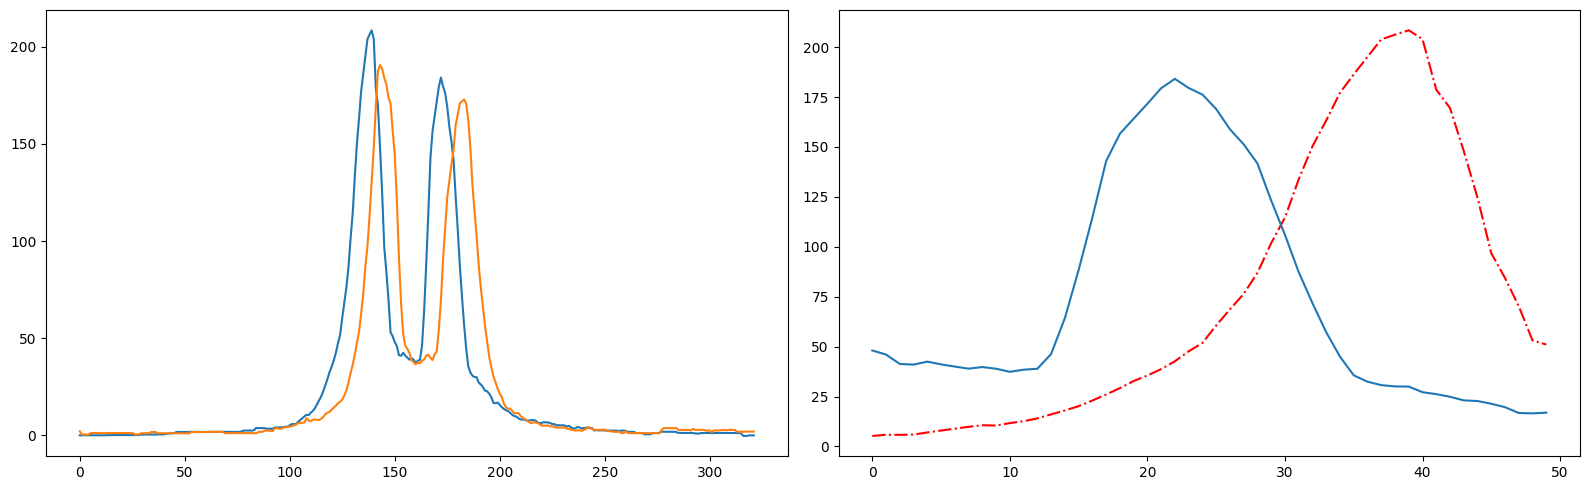

In [322]:
plt.figure(figsize = [16,5])
plt.subplot(121)
plt.plot(img2[:, column_number])
plt.plot(img2[row_number,:])

plt.subplot(122)
plt.plot(img2[100:150,column_number],'r-.')
plt.plot(img2[150:200,column_number])
plt.tight_layout()
plt.show()

In [323]:
r1i = np.argmax(img2[100:150,column_number]) + 100 # row 1st index
r2i = np.argmax(img2[150:200,column_number]) + 150
rci = int((r1i + r2i) / 2)
print(r1i, r2i, rci)

139 172 155


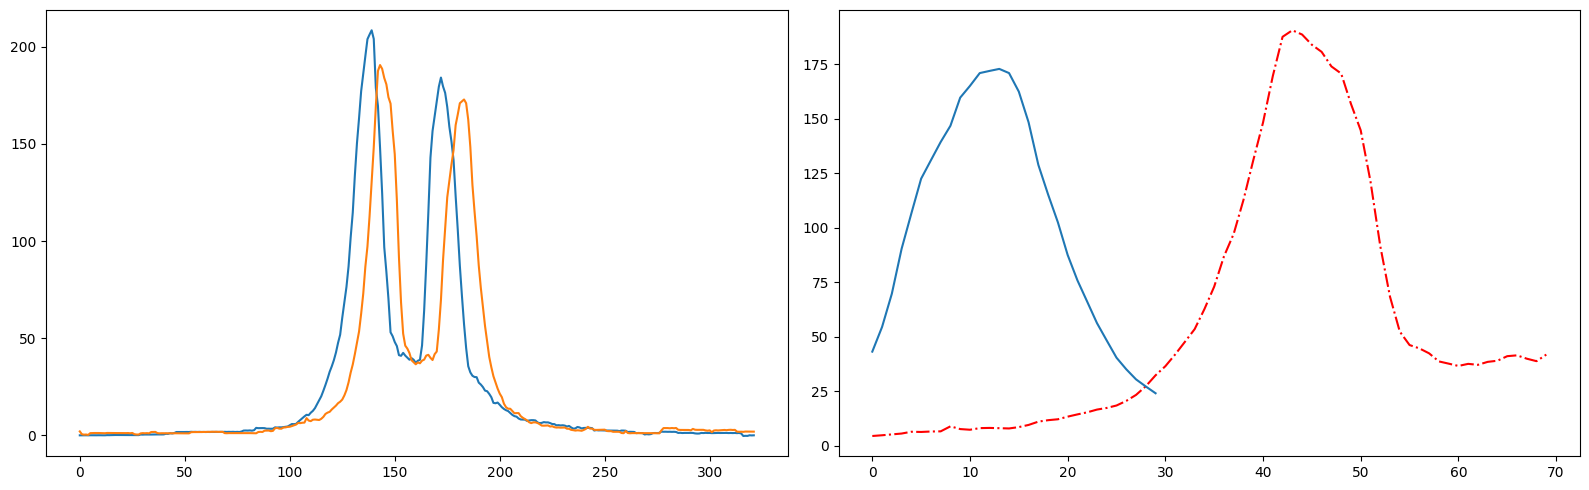

In [324]:
plt.figure(figsize = [16,5])
plt.subplot(121)
plt.plot(img2[:, column_number])
plt.plot(img2[row_number,:])

plt.subplot(122)
plt.plot(img2[row_number,100:170],'r-.')
plt.plot(img2[row_number,170:200])
plt.tight_layout()
plt.show()

In [325]:
c1i = np.argmax(img2[row_number,100:170]) + 100 # row 1st index
c2i = np.argmax(img2[row_number,170:200]) + 170
cci = int((c1i + c2i) / 2)
print(c1i, c2i, cci)

143 183 163


In [326]:
cr, cc = rci, cci  # The 280 shows the cut pixels along the column
sr0, er0, sc0, ec0 = 0, 2*cr, cc- cr, cc + cr
print('rotation center, radial piexles:',cr, cc, cr, 'the cut pixel is:', sr0, er0, sc0, ec0)

rotation center, radial piexles: 155 163 155 the cut pixel is: 0 310 8 318


In [327]:
# cc, cr = column_number, row_number
# sr0, er0, sc0, ec0 = 0, m-1, 0, n-1
# print('rotation center, radial piexles:',cr, cc, cr, 'the cut pixel is:', sr0, er0, sc0, ec0)

frame 6000 loaded.


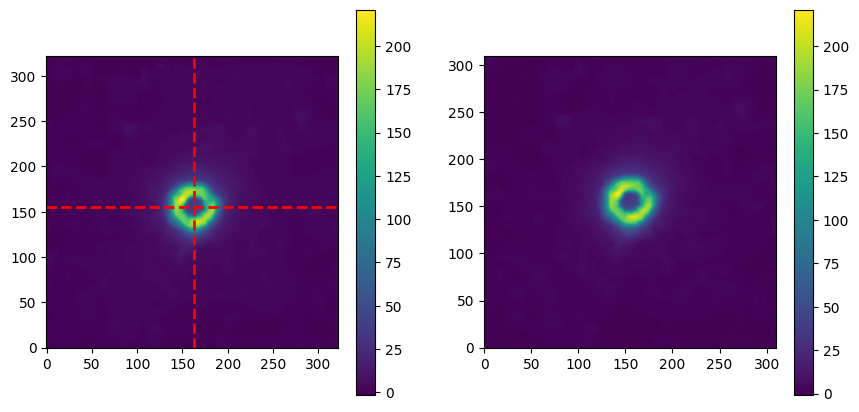

In [328]:
for i in range(6000,6001):
    hdu = fits.open(pathd + listd[st + i])
    print('frame', i, 'loaded.')  
    img = hdu[0].data
    cimg = img[sr0:er0,sc0:ec0]
plt.figure(figsize = [16,5],num = 'img, rimg, pimg')
plt.subplot(131)
plt.imshow(img, origin = 'lower')
plt.axhline(y=cr, color='r', linestyle='--', linewidth=2)
plt.axvline(x=cc, color='r', linestyle='--', linewidth=2)
plt.colorbar()
plt.subplot(132)
plt.imshow(cimg, origin = 'lower')
plt.colorbar()

---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 
- input: *.fits
- output: *.fits

STEP 2: rotation of the img, and then transfer to the polar form
- Define the rotation function and the polar form function

In [329]:
def rotimg(img2, cr, cc):
    img2 = img2 + 10
    sxy = 1  # Scaling factor
    rxy = 170  # Rotation angle required for visual alignment
    m, n = img2.shape
    matrix = cv2.getRotationMatrix2D((cr, cc), rxy, sxy)
    rimg2 = cv2.warpAffine(img2, matrix, (m, n))
    rimg2 = rimg2.astype('float32')
    rimg2 -= 10
    return rimg2
import math

def hstackpolar(img):
    m, n = img.shape
    img1 = np.zeros([m, n])
    for i in range(m):
        iml1 = img[i, 0:270]
        iml2 = img[i, 270:361]
        iml = np.concatenate((iml2, iml1), axis=0)
        img1[i, :] = iml
    return img1

# def cartesian_to_polar_cv2(image, r_bins=155, theta_bins=360):
#     """
#     Convert a Cartesian image to polar coordinates using cv2.linearPolar
#     and adjust the starting point to North (top).
    
#     Parameters:
#         image (numpy.ndarray): 2D grayscale image.
#         r_bins (int): Number of radial bins (vertical resolution).
#         theta_bins (int): Number of angular bins (horizontal resolution).
        
#     Returns:
#         numpy.ndarray: Adjusted polar coordinate representation of the image.
#     """
#     # Get image dimensions
#     h, w = image.shape
#     center = (w // 2, h // 2)  # Image center as the origin
#     max_radius = min(center)  # Maximum radius from the center to image edge

#     # Convert to polar coordinates using linearPolar
#     polar_image = cv2.linearPolar(
#         image,
#         center,
#         max_radius,
#         cv2.WARP_FILL_OUTLIERS
#     )
    
#     # Resize to desired output dimensions
#     polar_image = cv2.resize(polar_image, (theta_bins, r_bins))

#     # Rotate the polar image to start from North (Top)
#     #polar_image = np.roll(polar_image, shift=theta_bins // 4, axis=1)

#     return polar_image

def cartesian_to_polar_cv2(image, r_bins=155, theta_bins=360):
    """
    Convert a Cartesian image to polar coordinates with cv2.linearPolar,
    ensuring the angular starting point is North (top).
    
    Parameters:
        image (numpy.ndarray): 2D grayscale image.
        r_bins (int): Number of radial bins (vertical resolution).
        theta_bins (int): Number of angular bins (horizontal resolution).
        
    Returns:
        numpy.ndarray: Adjusted polar coordinate representation of the image.
    """
    # Get image dimensions
    h, w = image.shape
    center = (w // 2, h // 2)  # Image center as the origin
    max_radius = min(center)  # Maximum radius from the center to image edge

    # Create a polar coordinate grid
    r = np.linspace(0, max_radius, r_bins)
    theta = np.linspace(0, 2 * np.pi, theta_bins, endpoint=False)
    r_grid, theta_grid = np.meshgrid(r, theta)

    # Adjust theta to start from North (subtract π/2 for 90-degree counter-clockwise rotation)
    theta_grid = theta_grid - np.pi / 2
    theta_grid = np.mod(theta_grid, 2 * np.pi)  # Ensure angles are within [0, 2π]

    # Convert polar coordinates to Cartesian coordinates
    x_cart = center[0] + r_grid * np.cos(theta_grid)
    y_cart = center[1] + r_grid * np.sin(theta_grid)

    # Map the Cartesian coordinates to the original image
    polar_image = cv2.remap(
        image,
        x_cart.astype(np.float32),
        y_cart.astype(np.float32),
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )
    # Transpose the image to align correctly
    polar_image = polar_image.T
    
    return polar_image

In [330]:
fn,listd[st]

(13301, 'r2_r1_image_00000.fits')

---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 
STEP 2: rotation of the img, and then transfer to the polar form

frame 0 r2_r1_image_00000.fits loaded.
frame 1 r2_r1_image_00001.fits loaded.
frame 2 r2_r1_image_00002.fits loaded.
frame 3 r2_r1_image_00003.fits loaded.
frame 4 r2_r1_image_00004.fits loaded.
frame 5 r2_r1_image_00005.fits loaded.
frame 6 r2_r1_image_00006.fits loaded.
frame 7 r2_r1_image_00007.fits loaded.
frame 8 r2_r1_image_00008.fits loaded.
frame 9 r2_r1_image_00009.fits loaded.
frame 10 r2_r1_image_00010.fits loaded.
frame 11 r2_r1_image_00011.fits loaded.
frame 12 r2_r1_image_00012.fits loaded.
frame 13 r2_r1_image_00013.fits loaded.
frame 14 r2_r1_image_00014.fits loaded.
frame 15 r2_r1_image_00015.fits loaded.
frame 16 r2_r1_image_00016.fits loaded.
frame 17 r2_r1_image_00017.fits loaded.
frame 18 r2_r1_image_00018.fits loaded.
frame 19 r2_r1_image_00019.fits loaded.
frame 20 r2_r1_image_00020.fits loaded.
frame 21 r2_r1_image_00021.fits loaded.
frame 22 r2_r1_image_00022.fits loaded.
frame 23 r2_r1_image_00023.fits loaded.
frame 24 r2_r1_image_00024.fits loaded.
frame 25 r

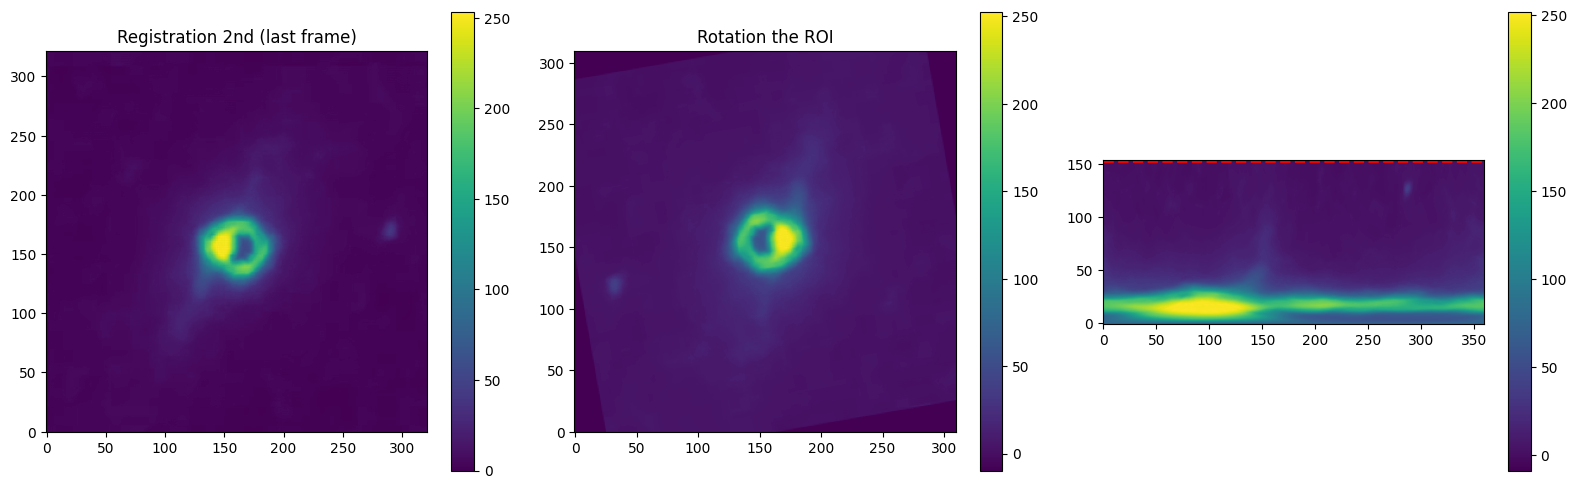

In [331]:
for i in range(fn):
    hdu = fits.open(pathd + listd[st + i])
    print('frame', i,listd[st + i], 'loaded.')  
    img = hdu[0].data
    cimg = img[sr0:er0,sc0:ec0]
    rimg = rotimg(cimg, cr, cr)
    pimg = cartesian_to_polar_cv2(rimg)
    # hdu1 = fits.PrimaryHDU()
    # hdu1.data = rimg
    # new_hdu = fits.HDUList([hdu1])
    # nname = 'rot_' + listd[st + i]         # nname: new name
    # new_hdu.writeto(dirrot + nname, overwrite=True) 
    pimg = pimg.astype('float32')
    hdu2 = fits.PrimaryHDU()
    hdu2.data = pimg
    new_hdu2 = fits.HDUList([hdu2])
    nname = 'pol_rot_' + listd[st + i]         # nname: new name
    new_hdu2.writeto(dirpol + nname, overwrite=True) 

pm,pn = pimg.shape
print('pimg.shape', pm, pn, int(pm/17))
r0 = 17   # corresponding solar radii

plt.figure(figsize=[16,5],num = 'img, rimg, pimg')
plt.subplot(131)
plt.imshow(img, origin = 'lower')
plt.title('Registration 2nd (last frame)')
plt.colorbar()
plt.subplot(132)
plt.imshow(rimg, origin = 'lower')
plt.title('Rotation the ROI')
plt.colorbar()
plt.subplot(133)
plt.imshow(pimg, origin = 'lower')
plt.axhline(y=9*r0, color='r', linestyle='--', linewidth=2)
plt.colorbar()
plt.tight_layout()

In [332]:
img.shape, rimg.shape, pimg.shape

((322, 322), (310, 310), (155, 360))

---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 

STEP 3: display the rotation and polar form result

frame 13300 r2_r1_image_06000.fits loaded.
pimg.shape 155 360 9


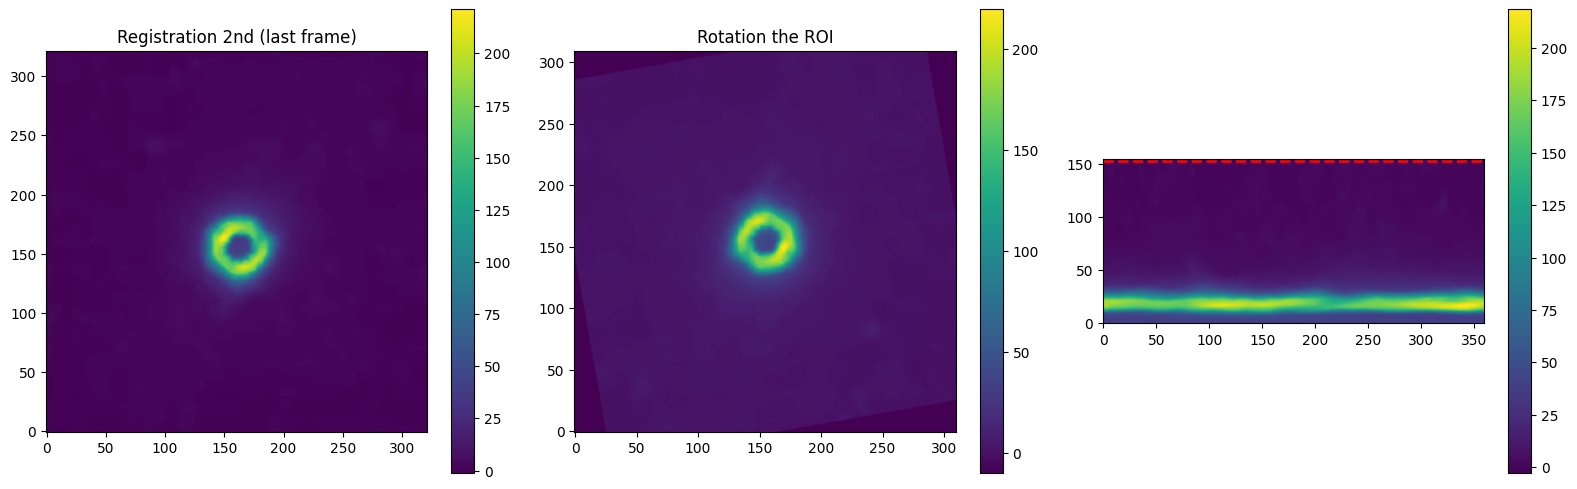

In [333]:
hdu = fits.open(pathd + listd[6000])
print('frame', i,listd[6000], 'loaded.')  
img = hdu[0].data
cimg = img[sr0:er0,sc0:ec0]
rimg = rotimg(cimg, cr, cr)
pimg = cartesian_to_polar(rimg)

pm,pn = pimg.shape
print('pimg.shape', pm, pn, int(pm/17))
r0 = 17   # corresponding solar radii

plt.figure(figsize=[16,5],num = 'img, rimg, pimg')
plt.subplot(131)
plt.imshow(img, origin = 'lower')
plt.title('Registration 2nd (last frame)')
plt.colorbar()
plt.subplot(132)
plt.imshow(rimg, origin = 'lower')
plt.title('Rotation the ROI')
plt.colorbar()
plt.subplot(133)
plt.imshow(pimg, origin = 'lower')
plt.axhline(y=9*r0, color='r', linestyle='--', linewidth=2)
plt.colorbar()
plt.tight_layout()

17 17


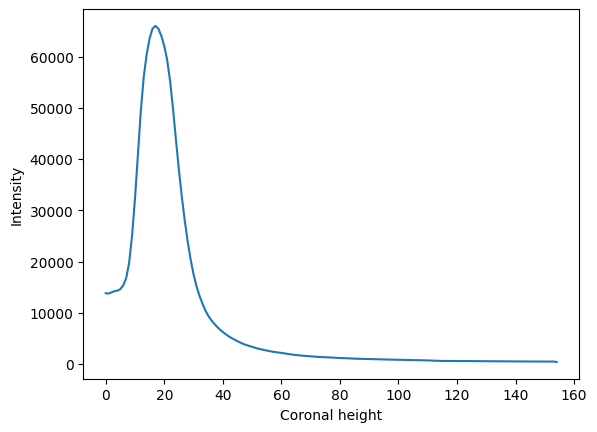

In [334]:
m,n = pimg.shape
rp = np.sum(pimg,axis=1)
plt.plot(rp)
plt.xlabel('Coronal height')
plt.ylabel('Intensity')
ridx = np.argmax(rp[0:50])
r0 = round(ridx/1.006)
print(ridx,r0)

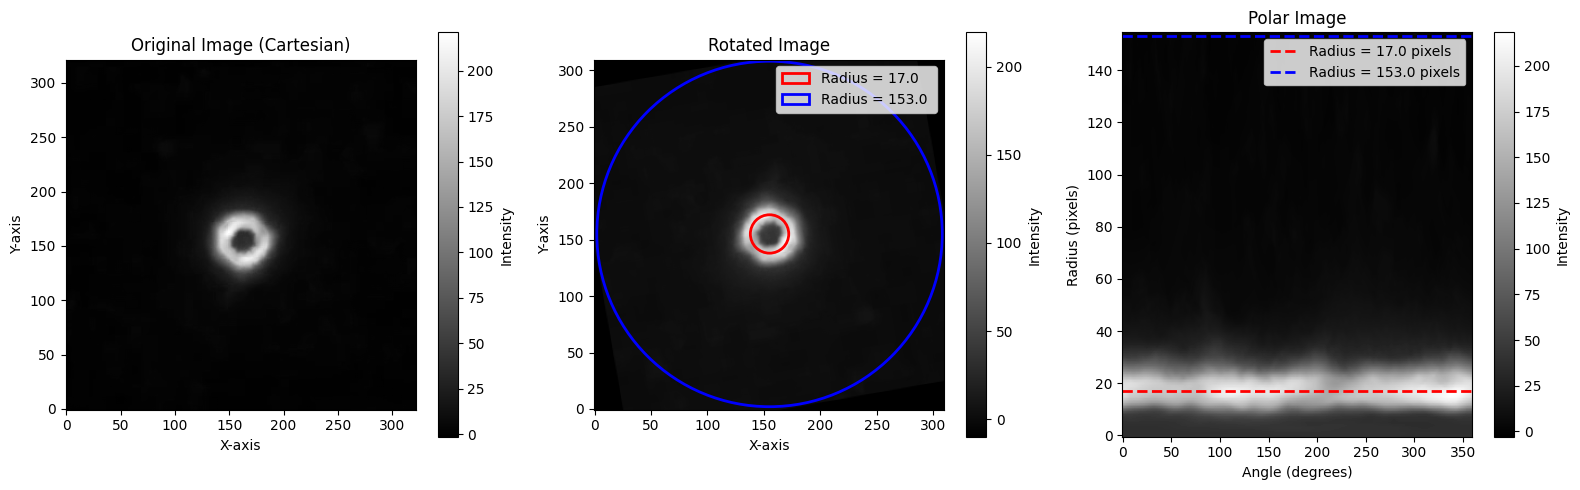

In [335]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

plt.figure(figsize=[16, 5], num='Comparison: Cartesian, Rotated, Polar')
# Display original image
plt.subplot(131)
plt.imshow(img, origin='lower', cmap='gray')
plt.title('Original Image (Cartesian)')
plt.colorbar(label='Intensity')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display rotated image and draw circles
plt.subplot(132)
plt.imshow(rimg, origin='lower', cmap='gray')
plt.title('Rotated Image')
plt.colorbar(label='Intensity')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add circles to the rotated image
circle1 = Circle((rimg.shape[1] // 2, rimg.shape[0] // 2), r0, color='r', fill=False, linewidth=2, label=f'Radius = {int(1 * r0):.1f}')
circle2 = Circle((rimg.shape[1] // 2, rimg.shape[0] // 2), int(9.0 * r0), color='b', fill=False, linewidth=2, label=f'Radius = {int(9.0 * r0):.1f} ')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.legend(loc='upper right')

# Display polar image with red line
plt.subplot(133)
plt.imshow(pimg, origin='lower', cmap='gray', aspect='auto')
plt.axhline(y=r0, color='r', linestyle='--', linewidth=2, label=f'Radius = {1 * r0:.1f} pixels')
plt.axhline(y=9*r0, color='b', linestyle='--', linewidth=2, label=f'Radius = {int(9.0 * r0):.1f} pixels')
plt.title('Polar Image')
plt.colorbar(label='Intensity')
plt.xlabel('Angle (degrees)')
plt.ylabel('Radius (pixels)')
plt.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


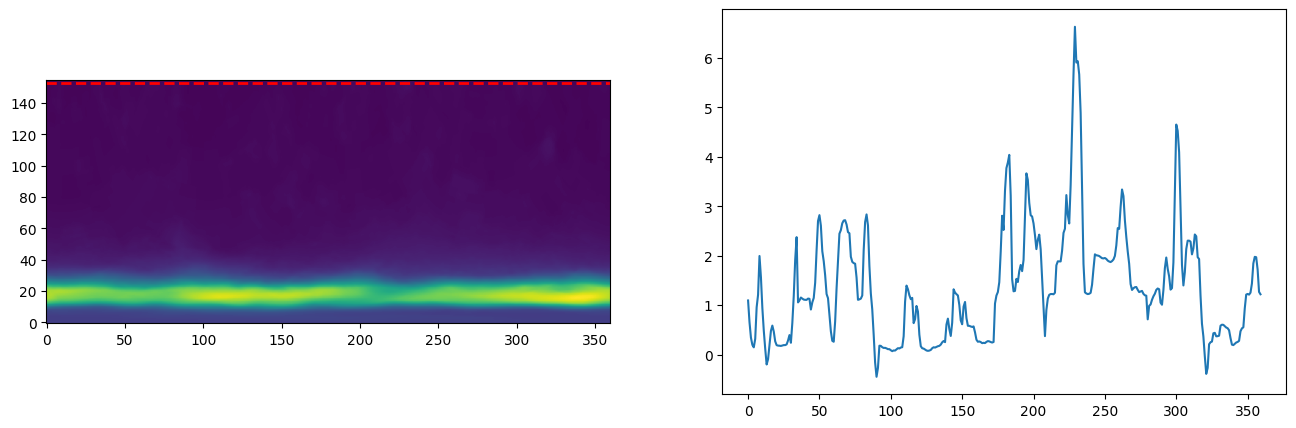

In [336]:
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.imshow(pimg,origin='lower')
plt.axhline(y=9*r0, color='r', linestyle='--', linewidth=2)
plt.subplot(122)
plt.plot(pimg[153])